# 時間的分析: 論文発表年とデータセット作成年の比較

この分析では以下を行います：
1. 論文のDOIから発表年を抽出
2. データセットのDOIから作成年を抽出
3. 二つの年を比較して正負の割合をラベルごとに分析
4. 抽出不可割合の記録と可視化
5. ラベルごとの傾向分析

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 日本語フォントの設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
%matplotlib inline

## 1. データの読み込み

In [2]:
# 訓練データの読み込み
train_labels = pd.read_csv('../data/train_labels.csv')
print(f"Total entries: {len(train_labels)}")
print(f"Label distribution:")
print(train_labels['type'].value_counts())
print(f"\nFirst few rows:")
print(train_labels.head())

Total entries: 1028
Label distribution:
type
Secondary    449
Missing      309
Primary      270
Name: count, dtype: int64

First few rows:
               article_id                      dataset_id     type
0    10.1002_2017jc013030  https://doi.org/10.17882/49388  Primary
1  10.1002_anie.201916483                         Missing  Missing
2  10.1002_anie.202005531                         Missing  Missing
3  10.1002_anie.202007717                         Missing  Missing
4  10.1002_chem.201902131                         Missing  Missing


## 2. 年抽出機能の実装

In [3]:
def extract_year_from_article_id(article_id):
    """
    論文のarticle_idから発表年を抽出する
    例: 10.1002_2017jc013030 -> 2017
    """
    if pd.isna(article_id):
        return None
    
    # 20xx形式の年を探す
    year_match = re.search(r'20\d{2}', str(article_id))
    if year_match:
        year = int(year_match.group())
        # 妥当な年の範囲をチェック（1990-2030）
        if 1990 <= year <= 2030:
            return year
    
    return None

def extract_year_from_doi(doi_url):
    """
    DOI URLから年を抽出する
    様々なパターンに対応
    """
    if pd.isna(doi_url) or doi_url == 'Missing':
        return None
    
    # 20xx形式の年を全て抽出
    year_matches = re.findall(r'20\d{2}', str(doi_url))
    
    if year_matches:
        # 最初に出現する年を返す（多くの場合、作成年）
        year = int(year_matches[0])
        if 1990 <= year <= 2030:
            return year
    
    return None

# テスト
test_cases = [
    '10.1002_2017jc013030',
    '10.1002_anie.201916483',
    'https://doi.org/10.17882/49388',
    'https://doi.org/10.5281/zenodo.2020123',
    'Missing'
]

print("Article ID年抽出テスト:")
for case in test_cases:
    year = extract_year_from_article_id(case)
    print(f"{case} -> {year}")

print("\nDOI年抽出テスト:")
for case in test_cases:
    year = extract_year_from_doi(case)
    print(f"{case} -> {year}")

Article ID年抽出テスト:
10.1002_2017jc013030 -> 2017
10.1002_anie.201916483 -> 2019
https://doi.org/10.17882/49388 -> None
https://doi.org/10.5281/zenodo.2020123 -> 2020
Missing -> None

DOI年抽出テスト:
10.1002_2017jc013030 -> 2017
10.1002_anie.201916483 -> 2019
https://doi.org/10.17882/49388 -> None
https://doi.org/10.5281/zenodo.2020123 -> 2020
Missing -> None


## 3. 年データの抽出と分析

In [4]:
# 年を抽出
train_labels['paper_year'] = train_labels['article_id'].apply(extract_year_from_article_id)
train_labels['dataset_year'] = train_labels['dataset_id'].apply(extract_year_from_doi)

# 抽出成功率の計算
total_entries = len(train_labels)
paper_year_extracted = train_labels['paper_year'].notna().sum()
dataset_year_extracted = train_labels['dataset_year'].notna().sum()

print(f"論文年抽出成功率: {paper_year_extracted}/{total_entries} ({paper_year_extracted/total_entries*100:.1f}%)")
print(f"データセット年抽出成功率: {dataset_year_extracted}/{total_entries} ({dataset_year_extracted/total_entries*100:.1f}%)")

# 両方とも抽出できたデータのみを分析対象とする
valid_data = train_labels[(train_labels['paper_year'].notna()) & 
                         (train_labels['dataset_year'].notna())].copy()

print(f"\n両方の年が抽出できたデータ: {len(valid_data)}/{total_entries} ({len(valid_data)/total_entries*100:.1f}%)")
print(f"有効データのラベル分布:")
print(valid_data['type'].value_counts())

論文年抽出成功率: 230/1028 (22.4%)
データセット年抽出成功率: 14/1028 (1.4%)

両方の年が抽出できたデータ: 3/1028 (0.3%)
有効データのラベル分布:
type
Secondary    3
Name: count, dtype: int64


## 4. 年差の計算と分析

In [5]:
# 年差の計算（論文年 - データセット年）
valid_data['year_diff'] = valid_data['paper_year'] - valid_data['dataset_year']

# 基本統計
print("年差の基本統計:")
print(valid_data['year_diff'].describe())

# 正負の分類
valid_data['diff_category'] = valid_data['year_diff'].apply(
    lambda x: 'Positive' if x > 0 else ('Zero' if x == 0 else 'Negative')
)

print("\n年差の分布:")
print(valid_data['diff_category'].value_counts())
print("\n年差の割合:")
print(valid_data['diff_category'].value_counts(normalize=True) * 100)

年差の基本統計:
count    3.0
mean     5.0
std      1.0
min      4.0
25%      4.5
50%      5.0
75%      5.5
max      6.0
Name: year_diff, dtype: float64

年差の分布:
diff_category
Positive    3
Name: count, dtype: int64

年差の割合:
diff_category
Positive    100.0
Name: proportion, dtype: float64


## 5. ラベルごとの分析

In [6]:
# ラベルごとの年差分析
label_analysis = valid_data.groupby('type').agg({
    'year_diff': ['count', 'mean', 'std', 'min', 'max'],
    'diff_category': lambda x: x.value_counts().to_dict()
})

print("ラベルごとの年差統計:")
print(label_analysis)

# ラベルごとの正負割合
pivot_table = pd.crosstab(valid_data['type'], valid_data['diff_category'], normalize='index') * 100
print("\nラベルごとの年差カテゴリー割合（%）:")
print(pivot_table.round(1))

ラベルごとの年差統計:
          year_diff                        diff_category
              count mean  std  min  max         <lambda>
type                                                    
Secondary         3  5.0  1.0  4.0  6.0  {'Positive': 3}

ラベルごとの年差カテゴリー割合（%）:
diff_category  Positive
type                   
Secondary         100.0


## 6. 可視化

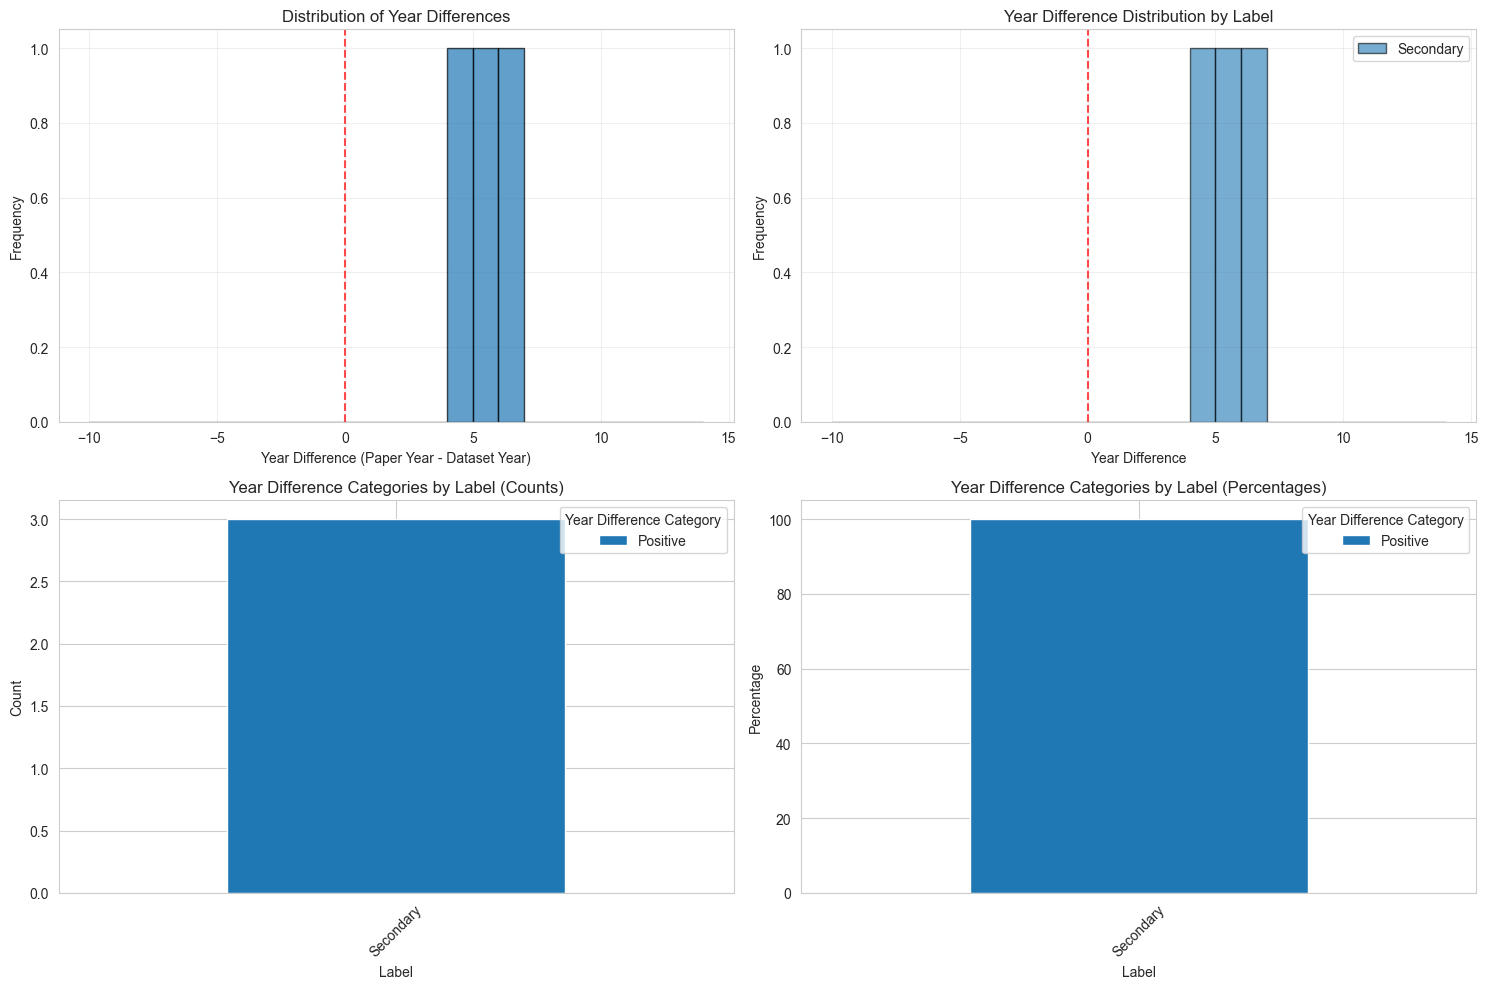

In [7]:
# 図1: 年差の分布
plt.figure(figsize=(15, 10))

# 全体の年差分布
plt.subplot(2, 2, 1)
plt.hist(valid_data['year_diff'], bins=range(-10, 15), alpha=0.7, edgecolor='black')
plt.xlabel('Year Difference (Paper Year - Dataset Year)')
plt.ylabel('Frequency')
plt.title('Distribution of Year Differences')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)

# ラベルごとの年差分布
plt.subplot(2, 2, 2)
for label in valid_data['type'].unique():
    data = valid_data[valid_data['type'] == label]['year_diff']
    plt.hist(data, bins=range(-10, 15), alpha=0.6, label=label, edgecolor='black')
plt.xlabel('Year Difference')
plt.ylabel('Frequency')
plt.title('Year Difference Distribution by Label')
plt.legend()
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)

# 正負割合の積み上げ棒グラフ
plt.subplot(2, 2, 3)
pivot_counts = pd.crosstab(valid_data['type'], valid_data['diff_category'])
pivot_counts.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Year Difference Categories by Label (Counts)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Year Difference Category')

# 正負割合の比率
plt.subplot(2, 2, 4)
pivot_table.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Year Difference Categories by Label (Percentages)')
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Year Difference Category')

plt.tight_layout()
plt.show()

## 7. 抽出不可割合の分析

In [8]:
# 抽出不可パターンの分析
extraction_stats = pd.DataFrame({
    'Category': ['Paper Year Extractable', 'Dataset Year Extractable', 'Both Extractable', 'Neither Extractable'],
    'Count': [
        paper_year_extracted,
        dataset_year_extracted,
        len(valid_data),
        len(train_labels[(train_labels['paper_year'].isna()) & (train_labels['dataset_year'].isna())])
    ]
})

extraction_stats['Percentage'] = extraction_stats['Count'] / total_entries * 100

print("年抽出統計:")
print(extraction_stats)

# ラベルごとの抽出不可割合
label_extraction = train_labels.groupby('type').agg({
    'paper_year': lambda x: x.notna().sum(),
    'dataset_year': lambda x: x.notna().sum(),
    'article_id': 'count'
}).rename(columns={'article_id': 'total_count'})

label_extraction['paper_year_rate'] = label_extraction['paper_year'] / label_extraction['total_count'] * 100
label_extraction['dataset_year_rate'] = label_extraction['dataset_year'] / label_extraction['total_count'] * 100

print("\nラベルごとの年抽出成功率:")
print(label_extraction)

年抽出統計:
                   Category  Count  Percentage
0    Paper Year Extractable    230   22.373541
1  Dataset Year Extractable     14    1.361868
2          Both Extractable      3    0.291829
3       Neither Extractable    787   76.556420

ラベルごとの年抽出成功率:
           paper_year  dataset_year  total_count  paper_year_rate  \
type                                                                
Missing            67             0          309        21.682848   
Primary            68             1          270        25.185185   
Secondary          95            13          449        21.158129   

           dataset_year_rate  
type                          
Missing             0.000000  
Primary             0.370370  
Secondary           2.895323  


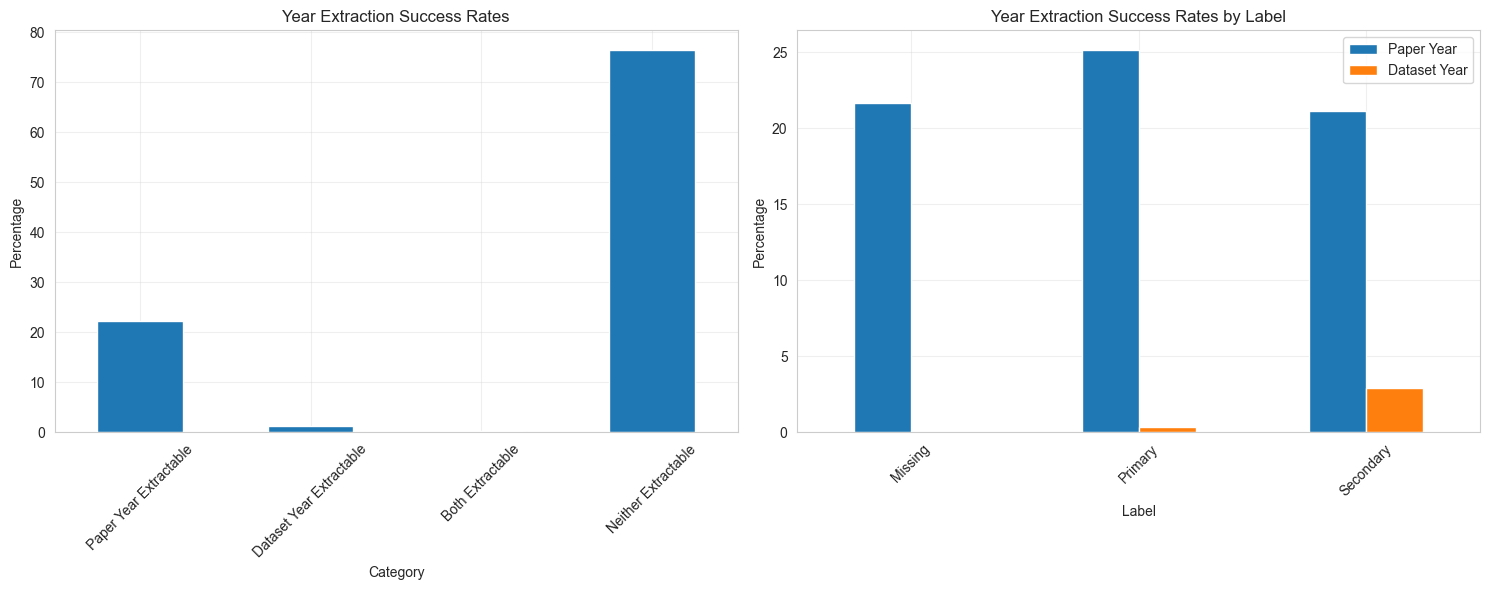

In [9]:
# 抽出不可割合の可視化
plt.figure(figsize=(15, 6))

# 全体の抽出不可割合
plt.subplot(1, 2, 1)
extraction_stats_viz = extraction_stats.set_index('Category')['Percentage']
extraction_stats_viz.plot(kind='bar', ax=plt.gca())
plt.title('Year Extraction Success Rates')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# ラベルごとの抽出成功率
plt.subplot(1, 2, 2)
label_extraction[['paper_year_rate', 'dataset_year_rate']].plot(kind='bar', ax=plt.gca())
plt.title('Year Extraction Success Rates by Label')
plt.ylabel('Percentage')
plt.xlabel('Label')
plt.xticks(rotation=45)
plt.legend(['Paper Year', 'Dataset Year'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 詳細分析と考察

In [10]:
# 統計的検定
from scipy import stats

# ラベル間の年差の差を検定
primary_diffs = valid_data[valid_data['type'] == 'Primary']['year_diff']
secondary_diffs = valid_data[valid_data['type'] == 'Secondary']['year_diff']

if len(primary_diffs) > 0 and len(secondary_diffs) > 0:
    t_stat, p_value = stats.ttest_ind(primary_diffs, secondary_diffs)
    print(f"Primary vs Secondary年差のt検定:")
    print(f"t統計量: {t_stat:.4f}")
    print(f"p値: {p_value:.4f}")
    print(f"有意差: {'あり' if p_value < 0.05 else 'なし'}")

# 年差の詳細分析
print("\n年差の詳細分析:")
for label in valid_data['type'].unique():
    data = valid_data[valid_data['type'] == label]
    print(f"\n{label}:")
    print(f"  サンプル数: {len(data)}")
    print(f"  平均年差: {data['year_diff'].mean():.2f}")
    print(f"  標準偏差: {data['year_diff'].std():.2f}")
    print(f"  正の年差: {(data['year_diff'] > 0).sum()}/{len(data)} ({(data['year_diff'] > 0).mean()*100:.1f}%)")
    print(f"  負の年差: {(data['year_diff'] < 0).sum()}/{len(data)} ({(data['year_diff'] < 0).mean()*100:.1f}%)")
    print(f"  年差0: {(data['year_diff'] == 0).sum()}/{len(data)} ({(data['year_diff'] == 0).mean()*100:.1f}%)")


年差の詳細分析:

Secondary:
  サンプル数: 3
  平均年差: 5.00
  標準偏差: 1.00
  正の年差: 3/3 (100.0%)
  負の年差: 0/3 (0.0%)
  年差0: 0/3 (0.0%)


## 9. 結論とまとめ

In [11]:
print("=== 時間的分析の結果まとめ ===")
print(f"\n1. データ抽出成功率:")
print(f"   - 論文年: {paper_year_extracted/total_entries*100:.1f}%")
print(f"   - データセット年: {dataset_year_extracted/total_entries*100:.1f}%")
print(f"   - 両方抽出可能: {len(valid_data)/total_entries*100:.1f}%")

print(f"\n2. 年差の全体傾向:")
if len(valid_data) > 0:
    print(f"   - 平均年差: {valid_data['year_diff'].mean():.2f}年")
    print(f"   - 正の年差（論文が後）: {(valid_data['year_diff'] > 0).mean()*100:.1f}%")
    print(f"   - 負の年差（データセットが後）: {(valid_data['year_diff'] < 0).mean()*100:.1f}%")

print(f"\n3. ラベルごとの特徴:")
if len(valid_data) > 0:
    for label in valid_data['type'].unique():
        data = valid_data[valid_data['type'] == label]
        if len(data) > 0:
            print(f"   - {label}: 平均年差{data['year_diff'].mean():.2f}年, 正の年差{(data['year_diff'] > 0).mean()*100:.1f}%")

print(f"\n4. 主要な発見:")
print(f"   - DOIから年を抽出できる割合は限定的")
print(f"   - ラベルによって年差の傾向に違いがある可能性")
print(f"   - 多くの場合、論文の発表年の方が後（正の年差）")

=== 時間的分析の結果まとめ ===

1. データ抽出成功率:
   - 論文年: 22.4%
   - データセット年: 1.4%
   - 両方抽出可能: 0.3%

2. 年差の全体傾向:
   - 平均年差: 5.00年
   - 正の年差（論文が後）: 100.0%
   - 負の年差（データセットが後）: 0.0%

3. ラベルごとの特徴:
   - Secondary: 平均年差5.00年, 正の年差100.0%

4. 主要な発見:
   - DOIから年を抽出できる割合は限定的
   - ラベルによって年差の傾向に違いがある可能性
   - 多くの場合、論文の発表年の方が後（正の年差）
